# Compare YouTube Sharing Across Platforms

In early 2019, YouTube actively began to reduce recommendations to "borderline" content (generally identified as conspiracy theories) in its content recommendation algorithms. An open question exists, however, on whether this change to within-YouTube recommendation really has a main effect on the distribution of this content in the broader information ecosystem.

To examine this sharing behavior, we look at other platforms where YouTube content is often shared (i.e., Twitter and Reddit) to evaluate whether we see a major impact on YouTube sharing during this timeframe.

This script compares time series from both Twitter and Reddit to see if we see any significant difference in YouTube link sharing across the platforms.

## Relevant Articles

- https://youtube.googleblog.com/2019/01/continuing-our-work-to-improve.html
- https://digitalsocialcontract.net/youtube-stops-recommending-alt-right-videos-6523ed6af60f



In [1]:
%matplotlib inline

In [2]:
import json
import time
import gzip
import string
import datetime
import requests
import tldextract
import matplotlib
import urlexpander
import collections

import scipy.stats
import sklearn.preprocessing

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

from statsmodels.tsa.tsatools import lagmat

In [4]:
recs_youtube_daily_df_ = pd.read_csv(
    "./2021.timeseries/cons_recs_ts.csv",
    parse_dates=[0],
    index_col=0,
)

## Question 1: How much overlap exists between YouTube videos shared on Twitter and Reddit?

In [6]:
twitter_videos_df = pd.read_csv("./2021.timeseries/all_video_ids.csv.gz")
reddit_videos_df = pd.read_csv("./2021.timeseries/all_video_ids_reddit.csv.gz")

In [7]:
print("Twitter Videos:", twitter_videos_df.shape[0])
print("Reddit Videos:", reddit_videos_df.shape[0])

Twitter Videos: 2560335
Reddit Videos: 3641858


In [8]:
overlap = set(twitter_videos_df["video_id"]).intersection(reddit_videos_df["video_id"])
print("Overlap Amount:", len(overlap))

Overlap Amount: 214978


In [9]:
union = overlap = set(twitter_videos_df["video_id"]).union(reddit_videos_df["video_id"])
print("Union Amount:", len(union))

Union Amount: 5987215


## Question 2: How many AIN videos are shared in both platforms?

In [10]:
with gzip.open("./2021.timeseries/ain_video2chan.json.gz", "r") as in_file:
    ain_videos = json.load(in_file)

In [11]:
ain_video_ids = {k for k in ain_videos.keys()}

In [12]:
overlap_ain_twitter = ain_video_ids.intersection(twitter_videos_df["video_id"])
overlap_ain_reddit = ain_video_ids.intersection(reddit_videos_df["video_id"])

In [13]:
print("Twitter AIN Overlap:", len(overlap_ain_twitter))
print("Reddit AIN Overlap:", len(overlap_ain_reddit))


Twitter AIN Overlap: 2296
Reddit AIN Overlap: 5675


In [14]:
channels_twitter = collections.Counter([ain_videos[vid] for vid in overlap_ain_twitter])
channels_reddit = collections.Counter([ain_videos[vid] for vid in overlap_ain_reddit])


In [15]:
channels_twitter_df = pd.DataFrame(list(channels_twitter.items()), columns=["channel", "count"])
channels_reddit_df = pd.DataFrame(list(channels_reddit.items()), columns=["channel", "count"])

merged_df = channels_reddit_df.merge(
    channels_twitter_df, on="channel", suffixes=["_r", "_t"], how="outer").fillna(0)


In [16]:
merged_df.sort_values("count_t", ascending=False).head()

,channel,count_r,count_t
7,UC0rZoXAD5lxgBHMsjrGwWWQ,949,350.0
6,UCaeO5vkdj5xOQHp4UmIN6dw,359,277.0
18,UCzQUP1qoWDoEbmsQxvdjxgQ,365,166.0
4,UCIveFvW-ARp_B_RckhweNJw,191,149.0
15,UCG749Dj4V2fKa143f8sE60Q,252,127.0


In [17]:
merged_df.corr()

,count_r,count_t
count_r,1.000000,0.846754
count_t,0.846754,1.000000


In [18]:
cons_dist_df = pd.read_csv("./2021.timeseries/all_video_ids_reddit_conspiracy.csv")
cons_dist_df.shape

(7224, 1)

In [19]:
len(ain_video_ids.intersection(cons_dist_df["video_id"]))

137

In [20]:
cons_dist_df.sample(n=30)["video_id"]

2999    6QdUWtsjlXQ
7035    H8gwX89AdCE
3876    5cWm3pJXKis
6041    uvxoAXS-d6g
7128    h8DMudwjFu4
6451     pGeCodnypo
1325    VIjGq9p_6iY
545     meH-JXDTiMM
2918    ajSHSaqwgGs
2381    scpQxFf1uBM
5115    9DLuALBnolM
4047    4m2V2cN4Has
6277    VmvX7Ezekps
7090    7nXBOVlk_2g
144     EuwmWnphqII
6311    m2QY83Ock7s
3319    hVnR0seQDQ4
3844    oM34dBcLVGA
3278    omnskeu-puE
2379    _CvyipXlM3M
1891    41SxwmRUqEg
63      _UgpGi77P0s
5260    2Pik0pvgxzk
3060    5sSJ2wqVJz0
4094    oYhCQv5tNsQ
5246    -ZwkyZN9TXc
2945    ZsCQ0t-3t1I
4815    HvZpQ7a5Wfo
5440    b2VkC4SnwY0
315     -HzOqZeX3Yk
Name: video_id, dtype: object

## Question 3: Is there a correlation between sharing on Twitter and sharing on Reddit over time?

In [21]:
# sharing_twitter_df = pd.read_csv("frequency_all_videos/youtube_sharing_twitter.csv", 
#                                  index_col="date",
#                                  parse_dates=["date"]
#                                 ).drop(columns="date.1")
# sharing_reddit_df = pd.read_csv("frequency_all_videos/youtube_sharing_reddit.csv",
#                                  index_col="date",
#                                  parse_dates=["date"]
#                                ).drop(columns="date.1")




In [23]:
sharing_twitter_df = pd.read_csv("./2021.timeseries/youtube_sharing_twitter.csv", 
                                 index_col="date",
                                 parse_dates=["date"]
                                ).drop(columns="date.1")
sharing_reddit_df = pd.read_csv("./2021.timeseries/youtube_sharing_reddit.csv",
                                 index_col="date",
                                 parse_dates=["date"]
                               ).drop(columns="date.1")



In [24]:
joined_df = sharing_reddit_df\
    .join(sharing_twitter_df, lsuffix="_reddit", rsuffix="_twitter", how="inner")


In [25]:
joined_df.sum()

count_yt_reddit          6575613.0
count_ain_reddit           20097.0
count_cons_reddit           7524.0
count_msm_reddit           32210.0
count_cchan_reddit         12929.0
count_subs              78915116.0
count_yt_twitter         5931528.0
count_ain_twitter           7732.0
count_cons_twitter          9854.0
count_msm_twitter          14917.0
count_cchan_twitter        13679.0
count_tweets           827056843.0
dtype: float64

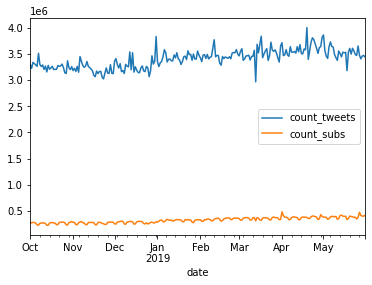

In [26]:
joined_df.resample("D").sum()[["count_tweets", "count_subs"]].plot()

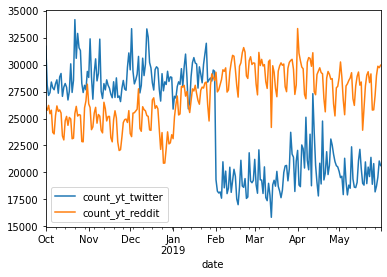

In [27]:
joined_df.resample("D").sum()[["count_yt_twitter", "count_yt_reddit"]].plot()

In [28]:
joined_df.resample("D").sum()[["count_yt_twitter", "count_yt_reddit"]].corr()

,count_yt_twitter,count_yt_reddit
count_yt_twitter,1.000000,-0.620201
count_yt_reddit,-0.620201,1.000000


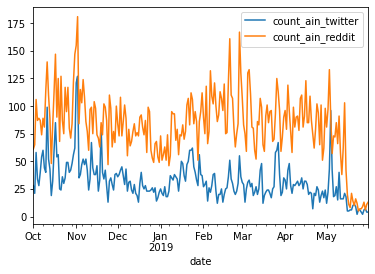

In [29]:
joined_df.resample("D").sum()[["count_ain_twitter", "count_ain_reddit"]].plot()

In [30]:
joined_df.resample("D").sum()[["count_ain_twitter", "count_ain_reddit"]].corr()

,count_ain_twitter,count_ain_reddit
count_ain_twitter,1.000000,0.649865
count_ain_reddit,0.649865,1.000000


# Question 4. Instrumenting Normalized Data

In [31]:
recs_youtube_daily_df = recs_youtube_daily_df_.resample("D").sum()

In [32]:
sharing_twitter_daily_df = sharing_twitter_df.resample("D").sum()
sharing_reddit_daily_df = sharing_reddit_df.resample("D").sum()

In [33]:
sharing_twitter_daily_df["count_yt_prop"] = \
    sharing_twitter_daily_df["count_yt"] / sharing_twitter_daily_df["count_tweets"]
sharing_twitter_daily_df["count_ain_prop"] = \
    sharing_twitter_daily_df["count_ain"] / sharing_twitter_daily_df["count_yt"]
sharing_twitter_daily_df["count_cons_prop"] = \
    sharing_twitter_daily_df["count_cons"] / sharing_twitter_daily_df["count_yt"]
sharing_twitter_daily_df["count_msm_prop"] = \
    sharing_twitter_daily_df["count_msm"] / sharing_twitter_daily_df["count_yt"]
sharing_twitter_daily_df["count_cchan_prop"] = \
    sharing_twitter_daily_df["count_cchan"] / sharing_twitter_daily_df["count_yt"]


In [34]:
sharing_reddit_daily_df["count_yt_prop"] = \
    sharing_reddit_daily_df["count_yt"] / sharing_reddit_daily_df["count_subs"]
sharing_reddit_daily_df["count_ain_prop"] = \
    sharing_reddit_daily_df["count_ain"] / sharing_reddit_daily_df["count_yt"]
sharing_reddit_daily_df["count_cons_prop"] = \
    sharing_reddit_daily_df["count_cons"] / sharing_reddit_daily_df["count_yt"]
sharing_reddit_daily_df["count_msm_prop"] = \
    sharing_reddit_daily_df["count_msm"] / sharing_reddit_daily_df["count_yt"]
sharing_reddit_daily_df["count_cchan_prop"] = \
    sharing_reddit_daily_df["count_cchan"] / sharing_reddit_daily_df["count_yt"]


In [35]:
sharing_twitter_daily_df_ = sharing_twitter_daily_df.sort_index()
sharing_reddit_daily_df_ = sharing_reddit_daily_df.sort_index()

In [36]:
date_threshold = datetime.datetime(2019,1,25)

In [37]:
thresh_idx_yt = np.argwhere(recs_youtube_daily_df.index == date_threshold)[0,0]
thresh_idx_yt

111

In [38]:
thresh_idx_twitter = np.argwhere(sharing_twitter_daily_df_.index == date_threshold)[0,0]
thresh_idx_reddit = np.argwhere(sharing_reddit_daily_df_.index == date_threshold)[0,0]
thresh_idx_twitter, thresh_idx_reddit

(116, 116)

In [39]:
recs_youtube_daily_df["treat"] = [1 if (x - thresh_idx_yt) >= 0 else 0 for x in range(recs_youtube_daily_df.shape[0])]
recs_youtube_daily_df["dist_to_treat_"] = [(x - thresh_idx_yt) for x in range(recs_youtube_daily_df.shape[0])]
recs_youtube_daily_df["dist_to_treat"] = recs_youtube_daily_df["dist_to_treat_"].apply(lambda x: max(0, x))


In [40]:
sharing_twitter_daily_df_["treat"] = [1 if (x - thresh_idx_twitter) >= 0 else 0 for x in range(sharing_twitter_daily_df_.shape[0])]
sharing_twitter_daily_df_["dist_to_treat_"] = [(x - thresh_idx_twitter) for x in range(sharing_twitter_daily_df_.shape[0])]
sharing_twitter_daily_df_["dist_to_treat"] = sharing_twitter_daily_df_["dist_to_treat_"].apply(lambda x: max(0, x))

sharing_reddit_daily_df_["treat"] = [1 if (x - thresh_idx_reddit) >= 0 else 0 for x in range(sharing_reddit_daily_df_.shape[0])]
sharing_reddit_daily_df_["dist_to_treat_"] = [(x - thresh_idx_reddit) for x in range(sharing_reddit_daily_df_.shape[0])]
sharing_reddit_daily_df_["dist_to_treat"] = sharing_reddit_daily_df_["dist_to_treat_"].apply(lambda x: max(0, x))


In [41]:
split_mean_df_t = sharing_twitter_daily_df_.groupby("treat").mean()
split_mean_df_t[["count_yt_prop", "count_ain_prop", "count_cons_prop", "count_msm_prop", "count_cchan_prop"]].T


treat,0,1
count_yt_prop,0.008806,0.005792
count_ain_prop,0.001336,0.001265
count_cons_prop,0.001824,0.001438
count_msm_prop,0.002104,0.003065
count_cchan_prop,0.002058,0.002658


In [42]:
split_mean_df_r = sharing_reddit_daily_df_.groupby("treat").mean()
split_mean_df_r[["count_yt_prop", "count_ain_prop", "count_cons_prop", "count_msm_prop", "count_cchan_prop"]].T

treat,0,1
count_yt_prop,0.089685,0.079592
count_ain_prop,0.003407,0.002761
count_cons_prop,0.001481,0.000872
count_msm_prop,0.004414,0.005259
count_cchan_prop,0.001907,0.002008


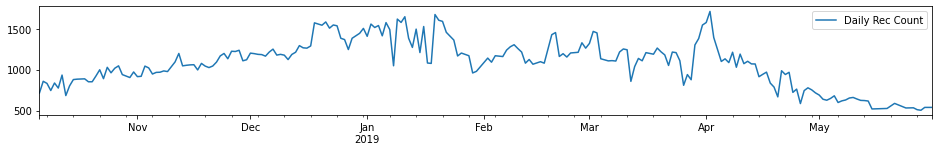

In [43]:
fig = plt.figure(figsize=(16,2))
ax = fig.add_subplot(1,1,1)
ax.grid()
recs_youtube_daily_df["cons_recs"].plot(ax=ax, label="Daily Rec Count")
ax.legend()


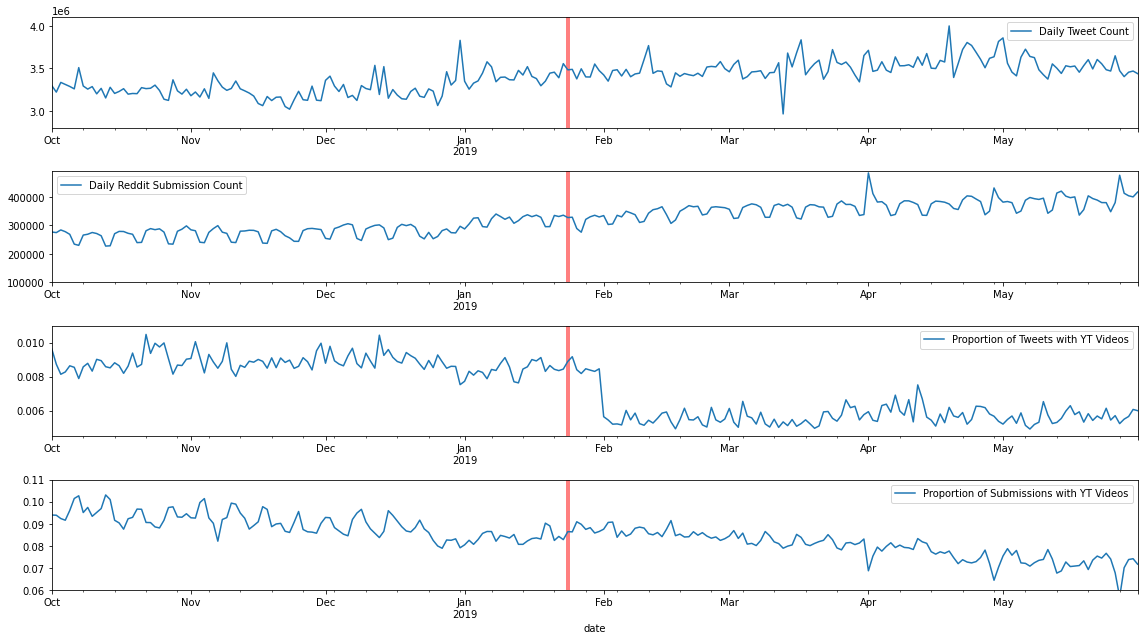

In [44]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(4,1,1)
ax.grid()
sharing_twitter_daily_df_["count_tweets"].plot(ax=ax, label="Daily Tweet Count")
ax.legend()
ax.bar(sharing_twitter_daily_df_.index[115], 5000000, color="red", alpha=0.5)
ax.set_ylim((2800000, 4100000))
ax.set_xlabel(None)

ax = fig.add_subplot(4,1,2)
ax.grid()
sharing_reddit_daily_df_["count_subs"].plot(ax=ax, label="Daily Reddit Submission Count")
ax.legend()
ax.bar(sharing_reddit_daily_df_.index[115], 5000000, color="red", alpha=0.5)
ax.set_ylim((100000, 490000))
ax.set_xlabel(None)

ax = fig.add_subplot(4,1,3)
ax.grid()
sharing_twitter_daily_df_["count_yt_prop"].plot(ax=ax, label="Proportion of Tweets with YT Videos")
ax.legend()
ax.bar(sharing_twitter_daily_df_.index[115], 1, color="red", alpha=0.5)
ax.set_ylim((0.0045, 0.011))
ax.set_xlabel(None)

ax = fig.add_subplot(4,1,4)
ax.grid()
sharing_reddit_daily_df_["count_yt_prop"].plot(ax=ax, label="Proportion of Submissions with YT Videos")
ax.legend()
ax.bar(sharing_reddit_daily_df_.index[115], 1, color="red", alpha=0.5)
ax.set_ylim((0.06, 0.11))

plt.tight_layout()
plt.savefig("both_platform_counts.pdf", format="pdf")
plt.show()

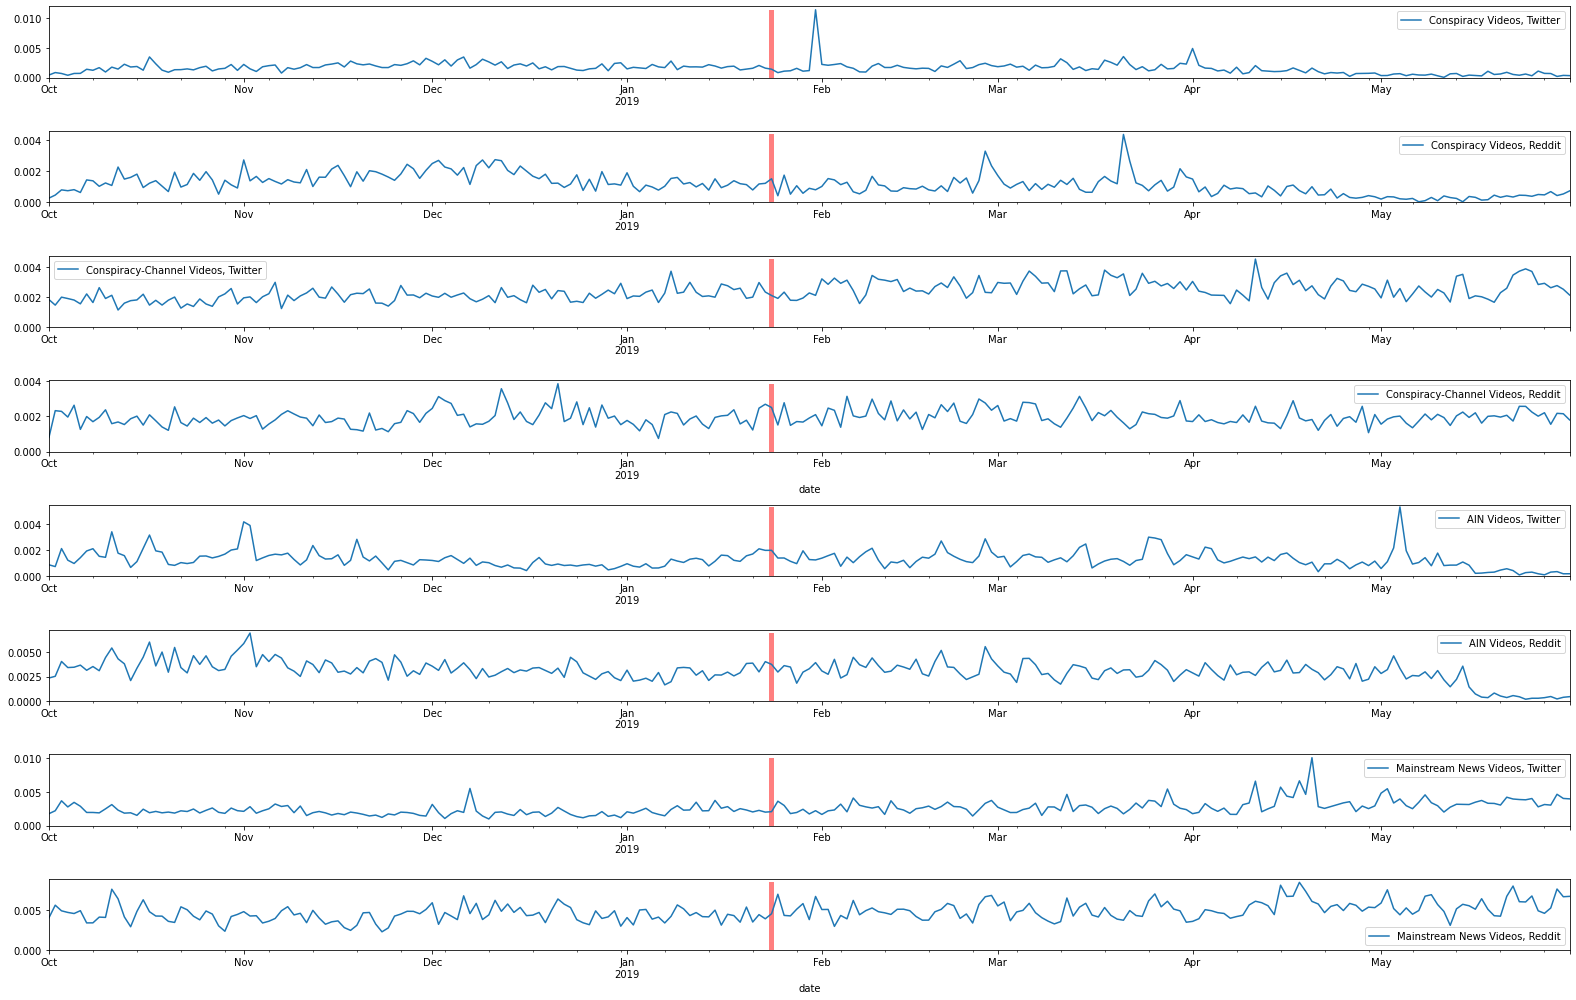

In [45]:
fig = plt.figure(figsize=(22,14))

row = 0

row += 1
ax = fig.add_subplot(8,1,row)
ax.grid()
sharing_twitter_daily_df_["count_cons_prop"].plot(ax=ax, label="Conspiracy Videos, Twitter")
ax.legend()
ax.bar(sharing_twitter_daily_df_.index[115], sharing_twitter_daily_df_["count_cons_prop"].max(), color="red", alpha=0.5)
ax.set_xlabel(None)

row += 1
ax = fig.add_subplot(8,1,row)
ax.grid()
sharing_reddit_daily_df_["count_cons_prop"].plot(ax=ax, label="Conspiracy Videos, Reddit")
ax.legend()
ax.bar(sharing_reddit_daily_df_.index[115], sharing_reddit_daily_df_["count_cons_prop"].max(), color="red", alpha=0.5)
ax.set_xlabel(None)


row += 1
ax = fig.add_subplot(8,1,row)
ax.grid()
sharing_twitter_daily_df_["count_cchan_prop"].plot(ax=ax, label="Conspiracy-Channel Videos, Twitter")
ax.legend()
ax.bar(sharing_twitter_daily_df_.index[115], sharing_twitter_daily_df_["count_cchan_prop"].max(), color="red", alpha=0.5)
ax.set_xlabel(None)

row += 1
ax = fig.add_subplot(8,1,row)
ax.grid()
sharing_reddit_daily_df_["count_cchan_prop"].plot(ax=ax, label="Conspiracy-Channel Videos, Reddit")
ax.legend()
ax.bar(sharing_reddit_daily_df_.index[115], sharing_reddit_daily_df_["count_cchan_prop"].max(), color="red", alpha=0.5)


row += 1
ax = fig.add_subplot(8,1,row)
ax.grid()
sharing_twitter_daily_df_["count_ain_prop"].plot(ax=ax, label="AIN Videos, Twitter")
ax.legend()
ax.bar(sharing_twitter_daily_df_.index[115], sharing_twitter_daily_df_["count_ain_prop"].max(), color="red", alpha=0.5)
ax.set_ylim((0, 0.0055))
ax.set_xlabel(None)

row += 1
ax = fig.add_subplot(8,1,row)
ax.grid()
sharing_reddit_daily_df_["count_ain_prop"].plot(ax=ax, label="AIN Videos, Reddit")
ax.legend()
ax.bar(sharing_reddit_daily_df_.index[115], sharing_reddit_daily_df_["count_ain_prop"].max(), color="red", alpha=0.5)
ax.set_xlabel(None)


row += 1
ax = fig.add_subplot(8,1,row)
ax.grid()
sharing_twitter_daily_df_["count_msm_prop"].plot(ax=ax, label="Mainstream News Videos, Twitter")
ax.legend()
ax.bar(sharing_twitter_daily_df_.index[115], sharing_twitter_daily_df_["count_msm_prop"].max(), color="red", alpha=0.5)
ax.set_xlabel(None)

row += 1
ax = fig.add_subplot(8,1,row)
ax.grid()
sharing_reddit_daily_df_["count_msm_prop"].plot(ax=ax, label="Mainstream News Videos, Reddit")
ax.legend()
ax.bar(sharing_reddit_daily_df_.index[115], sharing_reddit_daily_df_["count_msm_prop"].max(), color="red", alpha=0.5)



plt.tight_layout()
plt.savefig("both_platform_props.pdf", format="pdf")
plt.show()

In [52]:
for treated, group in recs_youtube_daily_df.groupby("treat"):
    print(treated)
    print(group[[
        "cons_recs", 
    ]].mean())

0
cons_recs    1178.333333
dtype: float64
1
cons_recs    990.047244
dtype: float64


In [53]:
for treated, group in sharing_twitter_daily_df_.groupby("treat"):
    print(treated)
    print(group[[
        "count_yt", 
        "count_ain", 
        "count_cons",
        "count_msm",
        "count_cchan",
    ]].mean())

0
count_yt       28829.810345
count_ain         38.517241
count_cons        52.560345
count_msm         60.741379
count_cchan       59.318966
dtype: float64
1
count_yt       20384.062992
count_ain         25.700787
count_cons        29.598425
count_msm         62.007874
count_cchan       53.566929
dtype: float64


In [54]:
for treated, group in sharing_reddit_daily_df_.groupby("treat"):
    print(treated)
    print(group[[
        "count_yt", 
        "count_ain", 
        "count_cons",
        "count_msm",
        "count_cchan",
    ]].mean())

0
count_yt       25165.939655
count_ain         85.767241
count_cons        37.155172
count_msm        111.491379
count_cchan       48.103448
dtype: float64
1
count_yt       28828.921260
count_ain         80.102362
count_cons        25.377953
count_msm        151.921260
count_cchan       57.984252
dtype: float64


In [55]:
for treated, group in sharing_twitter_daily_df_.groupby("treat"):
    print(treated)
    print(group[[
        "count_yt_prop", 
        "count_ain_prop", 
        "count_cons_prop",
        "count_msm_prop",
        "count_cchan_prop",
    ]].mean())

0
count_yt_prop       0.008806
count_ain_prop      0.001336
count_cons_prop     0.001824
count_msm_prop      0.002104
count_cchan_prop    0.002058
dtype: float64
1
count_yt_prop       0.005792
count_ain_prop      0.001265
count_cons_prop     0.001438
count_msm_prop      0.003065
count_cchan_prop    0.002658
dtype: float64


In [56]:
for treated, group in sharing_reddit_daily_df_.groupby("treat"):
    print(treated)
    print(group[[
        "count_yt_prop", 
        "count_ain_prop", 
        "count_cons_prop",
        "count_msm_prop",
        "count_cchan_prop",
    ]].mean())

0
count_yt_prop       0.089685
count_ain_prop      0.003407
count_cons_prop     0.001481
count_msm_prop      0.004414
count_cchan_prop    0.001907
dtype: float64
1
count_yt_prop       0.079592
count_ain_prop      0.002761
count_cons_prop     0.000872
count_msm_prop      0.005259
count_cchan_prop    0.002008
dtype: float64


In [57]:
recs_youtube_daily_df["cons_recs_lag"] = recs_youtube_daily_df["cons_recs"].shift()
recs_youtube_daily_df = recs_youtube_daily_df.dropna()

In [58]:
for col in [
    "count_yt", "count_ain", "count_cons", "count_msm", "count_cchan",
    "count_yt_prop", "count_ain_prop", "count_cons_prop", "count_msm_prop", "count_cchan_prop",
]:
    sharing_twitter_daily_df_[col + "_lag"] = sharing_twitter_daily_df_[col].shift()
    sharing_reddit_daily_df_[col + "_lag"] = sharing_reddit_daily_df_[col].shift()

In [59]:
sharing_twitter_daily_df_ = sharing_twitter_daily_df_.dropna()
sharing_reddit_daily_df_ = sharing_reddit_daily_df_.dropna()

# Impact in YouTube

In [60]:
exog = recs_youtube_daily_df[[
    "all_recs",
    "cons_recs_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["cons_recs_lag"] = np.log(exog["cons_recs_lag"] + 1)
exog["all_recs"] = np.log(exog["all_recs"] + 1)

mod = sm.OLS(np.log(recs_youtube_daily_df[["cons_recs"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              cons_recs   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.471e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:02:21   Log-Likelihood:                          194.01
No. Observations:                 237   AIC:                                     -380.0
Df Residuals:                     233   BIC:                                     -366.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
all_recs          0.0760      0.020      3.777      0.000       0.036       0.116
cons_recs_lag     0.8951      0.028     32.004      0.000       0.840       0.950
treat             0.0258      0.023      1.104      0.271      -0.020       0.072
dist_to_treat    -0.0009      0.000     -2.665      0.008      -0.002      -0.000
==============================================================================
Omnibus:                       29.850   Durbin-Watson:                   2.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.214
Skew:                           0.297   Prob(JB):                     1.60e-30
Kurtosis:                       6.680   Cond. No.                         279.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
res.params

all_recs         0.075963
cons_recs_lag    0.895061
treat            0.025836
dist_to_treat   -0.000916
dtype: float64

In [62]:
res.pvalues

all_recs         2.015443e-04
cons_recs_lag    2.990646e-87
treat            2.706591e-01
dist_to_treat    8.232311e-03
dtype: float64

# Impact in Reddit

In [63]:
exog = sharing_reddit_daily_df_[[
    "count_subs",
    "count_yt_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_subs"] = np.log(exog["count_subs"] + 1)
exog["count_yt_lag"] = np.log(exog["count_yt_lag"] + 1)

mod = sm.OLS(np.log(sharing_reddit_daily_df_[["count_yt"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               count_yt   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.343e+06
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:02:25   Log-Likelihood:                          495.32
No. Observations:                 242   AIC:                                     -982.6
Df Residuals:                     238   BIC:                                     -968.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
count_subs        0.4829      0.023     20.942      0.000       0.437       0.528
count_yt_lag      0.4021      0.029     14.081      0.000       0.346       0.458
treat             0.0184      0.006      2.889      0.004       0.006       0.031
dist_to_treat    -0.0010   8.93e-05    -10.805      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        6.244   Durbin-Watson:                   1.418
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.880
Skew:                          -0.253   Prob(JB):                       0.0321
Kurtosis:                       3.653   Cond. No.                         976.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
exog = sharing_reddit_daily_df_[[
    "count_yt",
    "count_ain_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_yt"] = np.log(exog["count_yt"] + 1)
exog["count_ain_lag"] = np.log(exog["count_ain_lag"] + 1)

mod = sm.OLS(np.log(sharing_reddit_daily_df_[["count_ain"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              count_ain   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.296e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   4.10e-277
Time:                        18:02:25   Log-Likelihood:                         -47.641
No. Observations:                 242   AIC:                                      103.3
Df Residuals:                     238   BIC:                                      117.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
count_yt          0.1073      0.019      5.728      0.000       0.070       0.144
count_ain_lag     0.7554      0.042     17.796      0.000       0.672       0.839
treat             0.1237      0.063      1.966      0.050      -0.000       0.248
dist_to_treat    -0.0033      0.001     -3.741      0.000      -0.005      -0.002
==============================================================================
Omnibus:                        1.606   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                1.339
Skew:                          -0.171   Prob(JB):                        0.512
Kurtosis:                       3.124   Cond. No.                         184.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
print(res.pvalues)

count_yt         3.052550e-08
count_ain_lag    1.267065e-45
treat            5.044268e-02
dist_to_treat    2.297341e-04
dtype: float64


In [67]:
exog = sharing_reddit_daily_df_[[
    "count_yt",
    "count_cons_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_yt"] = np.log(exog["count_yt"] + 1)
exog["count_cons_lag"] = np.log(exog["count_cons_lag"] + 1)

mod = sm.OLS(np.log(sharing_reddit_daily_df_[["count_cons"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             count_cons   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              3832.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   1.04e-214
Time:                        18:02:32   Log-Likelihood:                         -131.07
No. Observations:                 242   AIC:                                      270.1
Df Residuals:                     238   BIC:                                      284.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
count_yt           0.1843      0.020      9.210      0.000       0.145       0.224
count_cons_lag     0.4815      0.056      8.645      0.000       0.372       0.591
treat              0.0586      0.085      0.693      0.489      -0.108       0.225
dist_to_treat     -0.0059      0.001     -4.874      0.000      -0.008      -0.004
==============================================================================
Omnibus:                       20.997   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.165
Skew:                          -0.438   Prob(JB):                     6.98e-10
Kurtosis:                       4.848   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
print(res.pvalues)

count_yt          1.752154e-17
count_cons_lag    8.025190e-16
treat             4.892541e-01
dist_to_treat     2.002890e-06
dtype: float64


In [69]:
exog = sharing_reddit_daily_df_[[
    "count_yt",
    "count_msm_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_yt"] = np.log(exog["count_yt"] + 1)
exog["count_msm_lag"] = np.log(exog["count_msm_lag"] + 1)

mod = sm.OLS(np.log(sharing_reddit_daily_df_[["count_msm"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              count_msm   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          3.247e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:02:32   Log-Likelihood:                          36.510
No. Observations:                 242   AIC:                                     -65.02
Df Residuals:                     238   BIC:                                     -51.06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
count_yt          0.3214      0.027     11.783      0.000       0.268       0.375
count_msm_lag     0.3068      0.059      5.223      0.000       0.191       0.422
treat             0.0971      0.043      2.265      0.024       0.013       0.182
dist_to_treat     0.0012      0.001      2.254      0.025       0.000       0.002
==============================================================================
Omnibus:                        0.310   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.856   Jarque-Bera (JB):                0.361
Skew:                          -0.085   Prob(JB):                        0.835
Kurtosis:                       2.916   Cond. No.                         259.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
print(res.pvalues)

count_yt         1.500009e-25
count_msm_lag    3.834153e-07
treat            2.439425e-02
dist_to_treat    2.511045e-02
dtype: float64


In [71]:
exog = sharing_reddit_daily_df_[[
    "count_yt",
    "count_cchan_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_yt"] = np.log(exog["count_yt"] + 1)
exog["count_cchan_lag"] = np.log(exog["count_cchan_lag"] + 1)

mod = sm.OLS(np.log(sharing_reddit_daily_df_[["count_cchan"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            count_cchan   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.712e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   1.96e-291
Time:                        18:02:32   Log-Likelihood:                          8.3958
No. Observations:                 242   AIC:                                     -8.792
Df Residuals:                     238   BIC:                                      5.164
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
count_yt            0.3169      0.024     13.484      0.000       0.271       0.363
count_cchan_lag     0.1696      0.062      2.756      0.006       0.048       0.291
treat               0.1627      0.049      3.318      0.001       0.066       0.259
dist_to_treat      -0.0008      0.001     -1.434      0.153      -0.002       0.000
==============================================================================
Omnibus:                        2.036   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.698
Skew:                          -0.151   Prob(JB):                        0.428
Kurtosis:                       3.277   Cond. No.                         240.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
print(res.pvalues)

count_yt           3.647651e-31
count_cchan_lag    6.312239e-03
treat              1.047746e-03
dist_to_treat      1.528555e-01
dtype: float64


# Impact in Twitter

In [73]:
exog = sharing_twitter_daily_df_[[
    "count_tweets",
    "count_yt_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_tweets"] = np.log(exog["count_tweets"] + 1)
exog["count_yt_lag"] = np.log(exog["count_yt_lag"] + 1)

mod = sm.OLS(np.log(sharing_twitter_daily_df_[["count_yt"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               count_yt   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.031e+06
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:02:32   Log-Likelihood:                          278.29
No. Observations:                 242   AIC:                                     -548.6
Df Residuals:                     238   BIC:                                     -534.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
count_tweets      0.3163      0.033      9.619      0.000       0.252       0.381
count_yt_lag      0.5378      0.048     11.194      0.000       0.443       0.632
treat            -0.1766      0.023     -7.704      0.000      -0.222      -0.131
dist_to_treat    -0.0002      0.000     -0.884      0.377      -0.001       0.000
==============================================================================
Omnibus:                       29.163   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.285
Skew:                           0.725   Prob(JB):                     2.42e-10
Kurtosis:                       4.514   Cond. No.                         662.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
print(res.pvalues)

count_tweets     1.026483e-18
count_yt_lag     1.207698e-23
treat            3.535966e-13
dist_to_treat    3.773720e-01
dtype: float64


In [75]:
exog = sharing_twitter_daily_df_[[
    "count_yt",
    "count_ain_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_yt"] = np.log(exog["count_yt"] + 1)
exog["count_ain_lag"] = np.log(exog["count_ain_lag"] + 1)

mod = sm.OLS(np.log(sharing_twitter_daily_df_[["count_ain"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              count_ain   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              4965.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   6.43e-228
Time:                        18:02:32   Log-Likelihood:                         -102.45
No. Observations:                 242   AIC:                                      212.9
Df Residuals:                     238   BIC:                                      226.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
count_yt          0.1330      0.018      7.274      0.000       0.097       0.169
count_ain_lag     0.6209      0.051     12.060      0.000       0.519       0.722
treat             0.0784      0.075      1.047      0.296      -0.069       0.226
dist_to_treat    -0.0036      0.001     -3.521      0.001      -0.006      -0.002
==============================================================================
Omnibus:                        8.666   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               13.308
Skew:                          -0.197   Prob(JB):                      0.00129
Kurtosis:                       4.079   Cond. No.                         169.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
print(res.pvalues)

count_yt         5.031118e-12
count_ain_lag    1.868348e-26
treat            2.962425e-01
dist_to_treat    5.152434e-04
dtype: float64


In [77]:
exog = sharing_twitter_daily_df_[[
    "count_yt",
    "count_cons_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_yt"] = np.log(exog["count_yt"] + 1)
exog["count_cons_lag"] = np.log(exog["count_cons_lag"] + 1)

mod = sm.OLS(np.log(sharing_twitter_daily_df_[["count_cons"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             count_cons   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              5169.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   5.63e-230
Time:                        18:02:32   Log-Likelihood:                         -111.92
No. Observations:                 242   AIC:                                      231.8
Df Residuals:                     238   BIC:                                      245.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
count_yt           0.2303      0.022     10.332      0.000       0.186       0.274
count_cons_lag     0.3997      0.058      6.937      0.000       0.286       0.513
treat              0.1246      0.078      1.599      0.111      -0.029       0.278
dist_to_treat     -0.0079      0.001     -6.636      0.000      -0.010      -0.006
==============================================================================
Omnibus:                       29.061   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.697
Skew:                           0.047   Prob(JB):                     1.72e-36
Kurtosis:                       7.040   Cond. No.                         170.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
print(res.pvalues)

count_yt          6.487059e-21
count_cons_lag    3.767698e-11
treat             1.111507e-01
dist_to_treat     2.160062e-10
dtype: float64


In [79]:
exog = sharing_twitter_daily_df_[[
    "count_yt",
    "count_msm_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_yt"] = np.log(exog["count_yt"] + 1)
exog["count_msm_lag"] = np.log(exog["count_msm_lag"] + 1)

mod = sm.OLS(np.log(sharing_twitter_daily_df_[["count_msm"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              count_msm   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.438e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   1.75e-282
Time:                        18:02:32   Log-Likelihood:                         -20.144
No. Observations:                 242   AIC:                                      48.29
Df Residuals:                     238   BIC:                                      62.24
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
count_yt          0.2611      0.024     10.717      0.000       0.213       0.309
count_msm_lag     0.3438      0.061      5.640      0.000       0.224       0.464
treat            -0.0506      0.053     -0.961      0.338      -0.154       0.053
dist_to_treat     0.0023      0.001      3.454      0.001       0.001       0.004
==============================================================================
Omnibus:                       18.586   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.687
Skew:                           0.509   Prob(JB):                     1.60e-06
Kurtosis:                       4.269   Cond. No.                         206.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
print(res.pvalues)

count_yt         3.994703e-22
count_msm_lag    4.801051e-08
treat            3.377652e-01
dist_to_treat    6.538627e-04
dtype: float64


In [81]:
exog = sharing_twitter_daily_df_[[
    "count_yt",
    "count_cchan_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["count_yt"] = np.log(exog["count_yt"] + 1)
exog["count_cchan_lag"] = np.log(exog["count_cchan_lag"] + 1)

mod = sm.OLS(np.log(sharing_twitter_daily_df_[["count_cchan"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            count_cchan   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          2.461e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   3.81e-310
Time:                        18:02:32   Log-Likelihood:                          48.544
No. Observations:                 242   AIC:                                     -89.09
Df Residuals:                     238   BIC:                                     -75.13
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
count_yt            0.2977      0.025     12.113      0.000       0.249       0.346
count_cchan_lag     0.2506      0.062      4.060      0.000       0.129       0.372
treat               0.0472      0.040      1.187      0.236      -0.031       0.126
dist_to_treat      -0.0003      0.000     -0.587      0.558      -0.001       0.001
==============================================================================
Omnibus:                        1.648   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.333
Skew:                          -0.157   Prob(JB):                        0.514
Kurtosis:                       3.183   Cond. No.                         276.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
print(res.pvalues)

count_yt           1.260442e-26
count_cchan_lag    6.672839e-05
treat              2.363879e-01
dist_to_treat      5.576607e-01
dtype: float64


# Impact Across Platforms

In [83]:
merged_daily_df = sharing_twitter_daily_df_\
    .join(sharing_reddit_daily_df_, how="inner", lsuffix="_tw", rsuffix="_rt")

In [84]:
exog = merged_daily_df[[
    "count_tweets",
    "count_subs",
    "count_yt_lag_rt",
    "count_yt_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_tweets"] = np.log(exog["count_tweets"] + 1)
exog["count_subs"] = np.log(exog["count_subs"] + 1)
exog["count_yt_lag_rt"] = np.log(exog["count_yt_lag_rt"] + 1)
exog["count_yt_lag_tw"] = np.log(exog["count_yt_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_yt_tw"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            count_yt_tw   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.006e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:02:32   Log-Likelihood:                          281.68
No. Observations:                 242   AIC:                                     -551.4
Df Residuals:                     236   BIC:                                     -530.4
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
count_tweets         0.3533      0.068      5.159      0.000       0.218       0.488
count_subs           0.1101      0.066      1.662      0.098      -0.020       0.241
count_yt_lag_rt     -0.2131      0.085     -2.496      0.013      -0.381      -0.045
count_yt_lag_tw      0.5596      0.048     11.579      0.000       0.464       0.655
treat_rt            -0.1551      0.026     -6.082      0.000      -0.205      -0.105
dist_to_treat_rt    -0.0004      0.000     -1.907      0.058      -0.001    1.39e-05
==============================================================================
Omnibus:                       30.004   Durbin-Watson:                   2.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.791
Skew:                           0.697   Prob(JB):                     9.35e-12
Kurtosis:                       4.760   Cond. No.                     1.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
exog = merged_daily_df[[
    "count_tweets",
    "count_subs",
    "count_yt_lag_rt",
    "count_yt_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_tweets"] = np.log(exog["count_tweets"] + 1)
exog["count_subs"] = np.log(exog["count_subs"] + 1)
exog["count_yt_lag_rt"] = np.log(exog["count_yt_lag_rt"] + 1)
exog["count_yt_lag_tw"] = np.log(exog["count_yt_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_yt_rt"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            count_yt_rt   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.310e+06
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:02:32   Log-Likelihood:                          498.64
No. Observations:                 242   AIC:                                     -985.3
Df Residuals:                     236   BIC:                                     -964.4
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
count_tweets         0.0667      0.028      2.387      0.018       0.012       0.122
count_subs           0.4522      0.027     16.730      0.000       0.399       0.505
count_yt_lag_rt      0.3795      0.035     10.893      0.000       0.311       0.448
count_yt_lag_tw     -0.0377      0.020     -1.910      0.057      -0.077       0.001
treat_rt             0.0113      0.010      1.088      0.278      -0.009       0.032
dist_to_treat_rt    -0.0010   8.91e-05    -10.814      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        9.904   Durbin-Watson:                   1.386
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.197
Skew:                          -0.336   Prob(JB):                      0.00225
Kurtosis:                       3.871   Cond. No.                     1.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
exog = merged_daily_df[[
    "count_yt_tw",
    "count_yt_rt",
    "count_ain_lag_rt",
    "count_ain_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_yt_tw"] = np.log(exog["count_yt_tw"] + 1)
exog["count_yt_rt"] = np.log(exog["count_yt_rt"] + 1)
exog["count_ain_lag_rt"] = np.log(exog["count_ain_lag_rt"] + 1)
exog["count_ain_lag_tw"] = np.log(exog["count_ain_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_ain_tw"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           count_ain_tw   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              3601.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   6.41e-229
Time:                        18:02:32   Log-Likelihood:                         -91.356
No. Observations:                 242   AIC:                                      194.7
Df Residuals:                     236   BIC:                                      215.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
count_yt_tw         -0.0947      0.208     -0.456      0.649      -0.504       0.314
count_yt_rt          0.1683      0.212      0.793      0.428      -0.250       0.586
count_ain_lag_rt     0.3198      0.072      4.464      0.000       0.179       0.461
count_ain_lag_tw     0.4026      0.069      5.817      0.000       0.266       0.539
treat_rt            -0.1723      0.125     -1.375      0.170      -0.419       0.075
dist_to_treat_rt    -0.0018      0.001     -1.719      0.087      -0.004       0.000
==============================================================================
Omnibus:                        9.499   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               13.770
Skew:                          -0.254   Prob(JB):                      0.00102
Kurtosis:                       4.052   Cond. No.                         732.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
exog = merged_daily_df[[
    "count_yt_tw",
    "count_yt_rt",
    "count_ain_lag_rt",
    "count_ain_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_yt_tw"] = np.log(exog["count_yt_tw"] + 1)
exog["count_yt_rt"] = np.log(exog["count_yt_rt"] + 1)
exog["count_ain_lag_rt"] = np.log(exog["count_ain_lag_rt"] + 1)
exog["count_ain_lag_tw"] = np.log(exog["count_ain_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_ain_rt"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           count_ain_rt   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              8738.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   5.22e-274
Time:                        18:02:32   Log-Likelihood:                         -45.261
No. Observations:                 242   AIC:                                      102.5
Df Residuals:                     236   BIC:                                      123.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
count_yt_tw         -0.3179      0.172     -1.853      0.065      -0.656       0.020
count_yt_rt          0.4280      0.175      2.440      0.015       0.082       0.773
count_ain_lag_rt     0.6964      0.059     11.763      0.000       0.580       0.813
count_ain_lag_tw     0.0771      0.057      1.348      0.179      -0.036       0.190
treat_rt            -0.0091      0.104     -0.088      0.930      -0.213       0.195
dist_to_treat_rt    -0.0033      0.001     -3.761      0.000      -0.005      -0.002
==============================================================================
Omnibus:                        0.776   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.539
Skew:                          -0.097   Prob(JB):                        0.764
Kurtosis:                       3.125   Cond. No.                         732.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
exog = merged_daily_df[[
    "count_yt_tw",
    "count_yt_rt",
    "count_cons_lag_rt",
    "count_cons_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_yt_tw"] = np.log(exog["count_yt_tw"] + 1)
exog["count_yt_rt"] = np.log(exog["count_yt_rt"] + 1)
exog["count_cons_lag_rt"] = np.log(exog["count_cons_lag_rt"] + 1)
exog["count_cons_lag_tw"] = np.log(exog["count_cons_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_cons_tw"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          count_cons_tw   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              3682.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   4.84e-230
Time:                        18:02:32   Log-Likelihood:                         -102.99
No. Observations:                 242   AIC:                                      218.0
Df Residuals:                     236   BIC:                                      238.9
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
count_yt_tw           0.2662      0.217      1.226      0.221      -0.162       0.694
count_yt_rt          -0.0642      0.224     -0.287      0.775      -0.505       0.377
count_cons_lag_rt     0.2550      0.060      4.250      0.000       0.137       0.373
count_cons_lag_tw     0.2393      0.068      3.500      0.001       0.105       0.374
treat_rt              0.1000      0.130      0.769      0.443      -0.156       0.356
dist_to_treat_rt     -0.0070      0.001     -5.836      0.000      -0.009      -0.005
==============================================================================
Omnibus:                       31.842   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.468
Skew:                           0.184   Prob(JB):                     3.23e-41
Kurtosis:                       7.285   Cond. No.                         734.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
exog = merged_daily_df[[
    "count_yt_tw",
    "count_yt_rt",
    "count_cons_lag_rt",
    "count_cons_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_yt_tw"] = np.log(exog["count_yt_tw"] + 1)
exog["count_yt_rt"] = np.log(exog["count_yt_rt"] + 1)
exog["count_cons_lag_rt"] = np.log(exog["count_cons_lag_rt"] + 1)
exog["count_cons_lag_tw"] = np.log(exog["count_cons_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_cons_rt"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          count_cons_rt   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              2699.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   2.52e-214
Time:                        18:02:32   Log-Likelihood:                         -123.51
No. Observations:                 242   AIC:                                      259.0
Df Residuals:                     236   BIC:                                      280.0
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
count_yt_tw          -0.5922      0.236     -2.505      0.013      -1.058      -0.126
count_yt_rt           0.7439      0.244      3.052      0.003       0.264       1.224
count_cons_lag_rt     0.3673      0.065      5.624      0.000       0.239       0.496
count_cons_lag_tw     0.2086      0.074      2.803      0.005       0.062       0.355
treat_rt             -0.2177      0.142     -1.537      0.126      -0.497       0.061
dist_to_treat_rt     -0.0046      0.001     -3.549      0.000      -0.007      -0.002
==============================================================================
Omnibus:                       22.982   Durbin-Watson:                   2.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.278
Skew:                          -0.421   Prob(JB):                     1.64e-12
Kurtosis:                       5.162   Cond. No.                         734.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
exog = merged_daily_df[[
    "count_yt_tw",
    "count_yt_rt",
    "count_msm_lag_rt",
    "count_msm_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_yt_tw"] = np.log(exog["count_yt_tw"] + 1)
exog["count_yt_rt"] = np.log(exog["count_yt_rt"] + 1)
exog["count_msm_lag_rt"] = np.log(exog["count_msm_lag_rt"] + 1)
exog["count_msm_lag_tw"] = np.log(exog["count_msm_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_msm_tw"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           count_msm_tw   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              9723.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   1.84e-279
Time:                        18:02:32   Log-Likelihood:                         -17.461
No. Observations:                 242   AIC:                                      46.92
Df Residuals:                     236   BIC:                                      67.85
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
count_yt_tw          0.0653      0.157      0.417      0.677      -0.244       0.374
count_yt_rt          0.1483      0.158      0.940      0.348      -0.163       0.459
count_msm_lag_rt     0.1621      0.087      1.858      0.064      -0.010       0.334
count_msm_lag_tw     0.2816      0.072      3.927      0.000       0.140       0.423
treat_rt            -0.1866      0.093     -2.006      0.046      -0.370      -0.003
dist_to_treat_rt     0.0023      0.001      3.396      0.001       0.001       0.004
==============================================================================
Omnibus:                       17.256   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.390
Skew:                           0.500   Prob(JB):                     8.34e-06
Kurtosis:                       4.149   Cond. No.                         742.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
exog = merged_daily_df[[
    "count_yt_tw",
    "count_yt_rt",
    "count_msm_lag_rt",
    "count_msm_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_yt_tw"] = np.log(exog["count_yt_tw"] + 1)
exog["count_yt_rt"] = np.log(exog["count_yt_rt"] + 1)
exog["count_msm_lag_rt"] = np.log(exog["count_msm_lag_rt"] + 1)
exog["count_msm_lag_tw"] = np.log(exog["count_msm_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_msm_rt"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           count_msm_rt   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          2.186e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   7.36e-321
Time:                        18:02:32   Log-Likelihood:                          38.716
No. Observations:                 242   AIC:                                     -65.43
Df Residuals:                     236   BIC:                                     -44.50
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
count_yt_tw         -0.2264      0.124     -1.821      0.070      -0.471       0.019
count_yt_rt          0.5384      0.125      4.303      0.000       0.292       0.785
count_msm_lag_rt     0.2633      0.069      3.805      0.000       0.127       0.400
count_msm_lag_tw     0.0807      0.057      1.420      0.157      -0.031       0.193
treat_rt             0.0134      0.074      0.182      0.855      -0.132       0.159
dist_to_treat_rt     0.0010      0.001      1.817      0.071   -8.13e-05       0.002
==============================================================================
Omnibus:                        0.020   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.990   Jarque-Bera (JB):                0.049
Skew:                          -0.021   Prob(JB):                        0.976
Kurtosis:                       2.945   Cond. No.                         742.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
exog = merged_daily_df[[
    "count_yt_tw",
    "count_yt_rt",
    "count_cchan_lag_rt",
    "count_cchan_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_yt_tw"] = np.log(exog["count_yt_tw"] + 1)
exog["count_yt_rt"] = np.log(exog["count_yt_rt"] + 1)
exog["count_cchan_lag_rt"] = np.log(exog["count_cchan_lag_rt"] + 1)
exog["count_cchan_lag_tw"] = np.log(exog["count_cchan_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_cchan_tw"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         count_cchan_tw   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.669e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   4.59e-307
Time:                        18:02:32   Log-Likelihood:                          51.637
No. Observations:                 242   AIC:                                     -91.27
Df Residuals:                     236   BIC:                                     -70.34
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
count_yt_tw            0.0245      0.114      0.215      0.830      -0.200       0.249
count_yt_rt            0.2857      0.119      2.407      0.017       0.052       0.519
count_cchan_lag_rt     0.0114      0.054      0.210      0.834      -0.096       0.119
count_cchan_lag_tw     0.2181      0.066      3.328      0.001       0.089       0.347
treat_rt              -0.0938      0.070     -1.344      0.180      -0.231       0.044
dist_to_treat_rt      -0.0003      0.000     -0.598      0.550      -0.001       0.001
==============================================================================
Omnibus:                        2.719   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.381
Skew:                          -0.226   Prob(JB):                        0.304
Kurtosis:                       3.181   Cond. No.                         730.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
exog = merged_daily_df[[
    "count_yt_tw",
    "count_yt_rt",
    "count_cchan_lag_rt",
    "count_cchan_lag_tw",
    "treat_rt",
    "dist_to_treat_rt"
]].copy()

exog["count_yt_tw"] = np.log(exog["count_yt_tw"] + 1)
exog["count_yt_rt"] = np.log(exog["count_yt_rt"] + 1)
exog["count_cchan_lag_rt"] = np.log(exog["count_cchan_lag_rt"] + 1)
exog["count_cchan_lag_tw"] = np.log(exog["count_cchan_lag_tw"] + 1)

mod = sm.OLS(np.log(merged_daily_df[["count_cchan_rt"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         count_cchan_rt   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.176e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                   3.69e-289
Time:                        18:02:32   Log-Likelihood:                          13.021
No. Observations:                 242   AIC:                                     -14.04
Df Residuals:                     236   BIC:                                      6.893
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
count_yt_tw           -0.3813      0.134     -2.850      0.005      -0.645      -0.118
count_yt_rt            0.6783      0.139      4.873      0.000       0.404       0.952
count_cchan_lag_rt     0.1420      0.064      2.224      0.027       0.016       0.268
count_cchan_lag_tw     0.0883      0.077      1.149      0.252      -0.063       0.240
treat_rt              -0.0069      0.082     -0.084      0.933      -0.168       0.154
dist_to_treat_rt      -0.0008      0.001     -1.454      0.147      -0.002       0.000
==============================================================================
Omnibus:                        4.527   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                5.048
Skew:                          -0.164   Prob(JB):                       0.0802
Kurtosis:                       3.627   Cond. No.                         730.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Compare Original Faddoul Dataset to Corrected

The original Faddoul dataset included 28 videos that were authored by mainstream media channels, making them likely false-positives. Here, we compare the coefficients in the original data's interrupted time series models to those coefficients from the corrected model.

In [95]:
corrected_recs_youtube_daily_df_ = pd.read_csv(
    "./2021.timeseries/corrected_cons_recs_ts.csv",
    parse_dates=[0],
    index_col=0,
)

corrected_recs_youtube_daily_df = corrected_recs_youtube_daily_df_.resample("D").sum()

In [96]:
corrected_recs_youtube_daily_df["treat"] = [1 if (x - thresh_idx_yt) >= 0 else 0 for x in range(corrected_recs_youtube_daily_df.shape[0])]
corrected_recs_youtube_daily_df["dist_to_treat_"] = [(x - thresh_idx_yt) for x in range(corrected_recs_youtube_daily_df.shape[0])]
corrected_recs_youtube_daily_df["dist_to_treat"] = corrected_recs_youtube_daily_df["dist_to_treat_"].apply(lambda x: max(0, x))


In [97]:
corrected_recs_youtube_daily_df["cons_recs_lag"] = corrected_recs_youtube_daily_df["cons_recs"].shift()
corrected_recs_youtube_daily_df = corrected_recs_youtube_daily_df.dropna()


In [98]:
corrected_recs_youtube_daily_df

,all_recs,cons_recs,treat,dist_to_treat_,dist_to_treat,cons_recs_lag
2018-10-07,18794.0,857.0,0,-110,0,715.0
2018-10-08,18607.0,830.0,0,-109,0,857.0
2018-10-09,18762.0,744.0,0,-108,0,830.0
2018-10-10,19018.0,835.0,0,-107,0,744.0
2018-10-11,18865.0,775.0,0,-106,0,835.0
...,...,...,...,...,...,...
2019-05-27,19275.0,528.0,1,122,122,528.0
2019-05-28,19472.0,528.0,1,123,123,528.0
2019-05-29,19500.0,528.0,1,124,124,528.0
2019-05-30,19397.0,528.0,1,125,125,528.0


In [99]:
exog = corrected_recs_youtube_daily_df[[
    "all_recs",
    "cons_recs_lag",
    "treat",
    "dist_to_treat"
]].copy()

exog["cons_recs_lag"] = np.log(exog["cons_recs_lag"] + 1)
exog["all_recs"] = np.log(exog["all_recs"] + 1)

mod = sm.OLS(np.log(corrected_recs_youtube_daily_df[["cons_recs"]] + 1), exog)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              cons_recs   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.510e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:03:54   Log-Likelihood:                          196.22
No. Observations:                 237   AIC:                                     -384.4
Df Residuals:                     233   BIC:                                     -370.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
all_recs          0.0748      0.020      3.792      0.000       0.036       0.114
cons_recs_lag     0.8966      0.027     32.665      0.000       0.843       0.951
treat             0.0258      0.023      1.112      0.267      -0.020       0.072
dist_to_treat    -0.0009      0.000     -2.710      0.007      -0.002      -0.000
==============================================================================
Omnibus:                       31.375   Durbin-Watson:                   2.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.939
Skew:                           0.322   Prob(JB):                     4.55e-33
Kurtosis:                       6.830   Cond. No.                         277.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
res.pvalues

all_recs         1.902487e-04
cons_recs_lag    6.051818e-89
treat            2.674019e-01
dist_to_treat    7.237504e-03
dtype: float64

In [101]:
res.params

all_recs         0.074823
cons_recs_lag    0.896606
treat            0.025845
dist_to_treat   -0.000937
dtype: float64